Tutorial taken from https://blog.statsbot.co/time-series-prediction-using-recurrent-neural-networks-lstms-807fa6ca7f

### How prediction machine learning problems are structured

    It is known as the one to many problem. The one to many problem starts like the one to one problem where we have an input to the model and the model generates one output. However, the output of the model is now fed back to the model as a new input. The model now can generate a new output and we can continue like this indefinitely. You can now see why these are known as recurrent neural networks

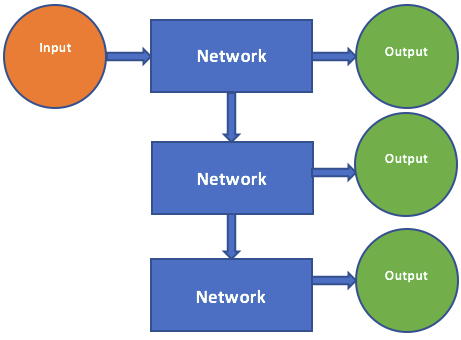

### Long Short-term Neural Network
    This model is organized in cells which include several operations. LSTM has an internal state variable, which is passed from one cell to another and modified by Operation Gates.
    
    1.  Forget Gate - It is a sigmoid layer that takes the output at t-1 and the current input at time t and concatenates them into a single tensor and applies a linear transformation followed by a sigmoid. Because of the sigmoid, the output of this gate is between 0 and 1. This number is multiplied with the internal state and that is why the gate is called a forget gate. If ft=0 then the previous internal state is completely forgotten, while if ft=1 it will be passed through unaltered.
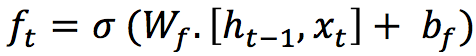

    


    2. Input Gate  -  
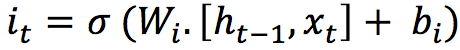
    
    The input gate takes the previous output and the new input and passes them through another sigmoid layer. This gate returns a value between 0 and 1. The value of the input gate is multiplied with the output of the candidate layer. This layer applies a hyperbolic tangent to the mix of input and previous output, returning a candidate vector to be added to the internal state.
    

    Candidate Layer:
    
   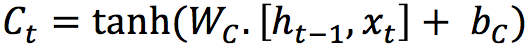

    The internal state is updated with this rule:
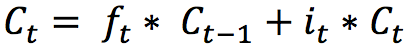

    .The previous state is multiplied by the forget gate and then added to the fraction of the new candidate allowed by the output gate.

    3. Output Gate- .The previous state is multiplied by the forget gate and then added to the fraction of the new candidate allowed by the output gate.
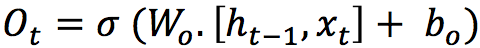

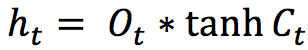

    These three gates described above have independent weights and biases, hence the network will learn how much of the past output to keep, how much of the current input to keep, and how much of the internal state to send out to the output.

# To summerize, by using a variation of neural networks that uses these gates to control input and output starting from the first input, the neural network can adapt and control what to learn from the new input and what to retain from the old input

### Using this tutorial to implement a multivariate forecaster (Our time series consists of two variables, price and signal)

Note this uses the Keras Deep Learning Library which requires Tensorflow

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/


In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

C:\Users\hgfddfgh\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [117]:
#Prepare data, read in data and use date as index
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y%m%d')
df = pd.read_csv("stockdata.csv", index_col='date', parse_dates=['date'])

In [118]:
#Drop empty rows and columns
df = df.dropna(how='any')
# Detect outliers in signal
sig_val = df['signal'].value_counts()
criteria = df[ (df['signal'] <= 2) | (df['signal'] >= 400) ]
df['signal'][criteria.index] = np.nan

# Detect outliers in price
sig_val = df['spy_close_price'].value_counts()
criteria = df[ df['spy_close_price'] >= 500 ]
df['spy_close_price'][criteria.index] = np.nan

#By replacing the outliers with nan, we are able to both drop nan data and outliers
df = df.dropna(how="any")
#Replace price column name for convenience
df.columns = ['signal', 'price']

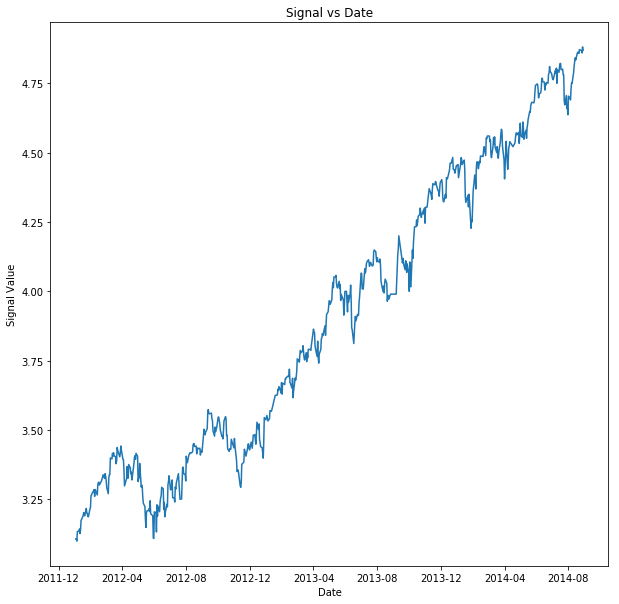

In [119]:
import matplotlib.pyplot as plt
#Plot both the signal and price

plt.figure(figsize=(10,10))
plt.title("Signal vs Date")
plt.ylabel("Signal Value")
plt.xlabel("Date")
plt.plot(df['signal'])
plt.show()

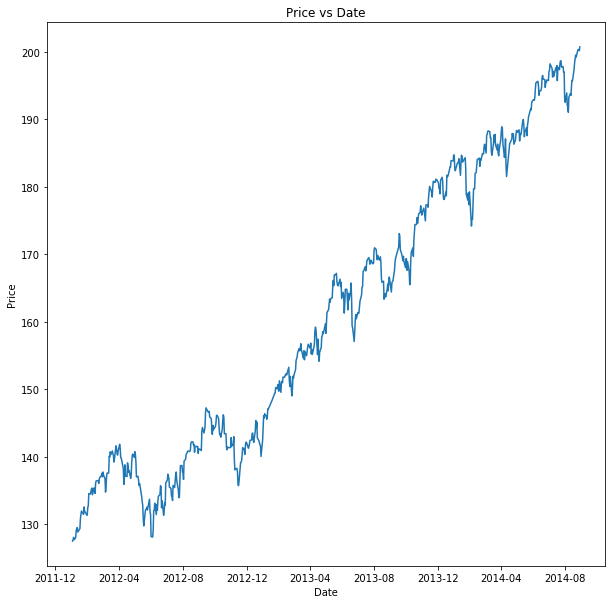

In [120]:
plt.figure(figsize=(10,10))
plt.title("Price vs Date")
plt.ylabel("Price")
plt.xlabel("Date")
plt.plot(df['price'])
plt.show()

### Informal analysis demonstrates that both graphs show a similar trend and shape, suggesting a correlation between signal and price

# Framing this into a supervised deep learning problem:

    We want to frame this as trying to predict the subsequent price by supplying the previous price and the current signal as inputs.
    
### What do we need to do to the dataframe:

1. Normalize features by scaling using a MinMaxVector

2. Lag the signal column (the input value) with respect to our price column (the output value)

In [121]:
from sklearn.preprocessing import MinMaxScaler

values = df.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values)

In [122]:
# Helpful function taken from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# The purpose of this function is to lag input with respect towards the output value.
# For our purposes, the signal will be lagged by one day with respect to the price.
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [123]:
lagged_dataframe = series_to_supervised(scaled_data)
#Drop current signal column, it is unneeded
lagged_dataframe.drop(lagged_dataframe.columns[[2]], axis=1, inplace=True)
lagged_dataframe.columns = ['lagged_signal', 'last_price', 'current_price']

In [193]:


#Split into training and test sets

values = lagged_dataframe.values
#657 entries in our dataframe, let us use 75% of our data

n_train_hours = int(.75 * len(values))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
# This is required for our neural network
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(492, 1, 2) (492,) (165, 1, 2) (165,)


In [125]:
# neural network
model = Sequential()
#Use the Long Short Term Memory NN
#input is time step, (lagged signal, price)
model.add(LSTM(50, input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 492 samples, validate on 165 samples
Epoch 1/50
 - 1s - loss: 0.2856 - val_loss: 0.7333
Epoch 2/50
 - 0s - loss: 0.2526 - val_loss: 0.6807
Epoch 3/50
 - 0s - loss: 0.2195 - val_loss: 0.6258
Epoch 4/50
 - 0s - loss: 0.1878 - val_loss: 0.5695
Epoch 5/50
 - 0s - loss: 0.1592 - val_loss: 0.5130
Epoch 6/50
 - 0s - loss: 0.1363 - val_loss: 0.4581
Epoch 7/50
 - 0s - loss: 0.1203 - val_loss: 0.4091
Epoch 8/50
 - 0s - loss: 0.1116 - val_loss: 0.3668
Epoch 9/50
 - 0s - loss: 0.1053 - val_loss: 0.3300
Epoch 10/50
 - 0s - loss: 0.1004 - val_loss: 0.2977
Epoch 11/50
 - 0s - loss: 0.0959 - val_loss: 0.2687
Epoch 12/50
 - 0s - loss: 0.0917 - val_loss: 0.2424
Epoch 13/50
 - 0s - loss: 0.0879 - val_loss: 0.2188
Epoch 14/50
 - 0s - loss: 0.0844 - val_loss: 0.1982
Epoch 15/50
 - 0s - loss: 0.0810 - val_loss: 0.1800
Epoch 16/50
 - 0s - loss: 0.0776 - val_loss: 0.1644
Epoch 17/50
 - 0s - loss: 0.0743 - val_loss: 0.1512
Epoch 18/50
 - 0s - loss: 0.0708 - val_loss: 0.1396
Epoch 19/50
 - 0s - loss: 0

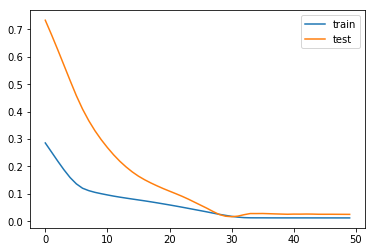

In [126]:
#Show important statistics regarding the NN
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## We can see from this plot how the LSTM Neural network is able to reduce loss by adapting with each successive epoch

## Both the train and test sets are able to improve in prediction based on signal.

In [183]:
#Evaluate predictive ability
predicted = model.predict(test_X)
#We want to reverse the minmax scalar to get the "true" value of the prediction
#To do so, we must get rid of time step which was added to allow the neural network to function
reverse_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
#This concatenates our predicted values for the price with the associated signal
reverse_Y = np.concatenate((reverse_X[:, 1:],predicted), axis=1)
unscaled_prediction = scaler.inverse_transform(reverse_Y)
unscaled_prediction = unscaled_prediction[:,1]
print(unscaled_prediction)

[184.74781683 184.74781683 183.95971728 182.53387384 184.26136687
 184.87734335 184.78987226 184.55492134 183.71290513 184.73181421
 184.29303172 181.83024297 180.93046547 181.82488404 180.84822239
 181.26328679 178.79442342 175.9955011  177.21366833 176.28051531
 178.53693703 179.35461547 178.88502783 179.40560391 178.13208865
 181.01211941 182.66203444 182.66203444 182.66203444 183.15575038
 183.84825316 184.16987221 185.26699645 185.32985048 184.75318013
 185.85475124 186.03815077 185.73463777 187.27364726 187.2058096
 187.92115768 188.14700976 187.5176403  188.26678284 188.48932704
 187.42071252 187.14348797 188.10927028 188.47016492 187.88724975
 187.53800687 186.35248638 186.68625468 187.85720393 186.56562626
 186.84944911 186.66034589 187.21169221 188.38590133 188.12336585
 187.78441318 186.87115105 186.35147395 185.22954063 186.5269529
 187.58773413 187.72566563 184.2311334  185.3541097  187.47157876
 185.74666919 185.3512164  187.23596888 187.90249741 188.84213091
 188.9707104

In [181]:
#Reverse true prices
true_price_scaled = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((reverse_X[:, 1:],true_price_scaled), axis=1)
true_price_unscaled = scaler.inverse_transform(inv_y)
true_price_unscaled = true_price_unscaled[:,1]
print(true_price_unscaled)

[184.69   182.885  182.36   183.48   183.52   183.64   184.14   181.685
 183.67   184.66   184.42   183.635  184.18   184.3    182.79   178.89
 178.01   179.07   177.35   179.23   178.18   174.17   175.385  175.17
 177.48   179.68   179.68   179.68   181.98   182.07   183.01   184.02
 184.24   183.02   184.1    183.89   184.91   184.84   184.85   185.82
 186.29   184.98   187.58   187.75   188.18   188.26   188.16   187.23
 187.28   185.18   184.66   186.33   187.66   186.66   187.747  186.2
 185.43   186.31   184.97   184.58   185.49   187.01   188.25   188.88
 188.63   186.4    184.34   185.1    187.09   183.155  181.51   186.39
 187.04   187.89   187.45   187.83   186.29   186.875  187.75   188.31
 188.325  188.06   188.42   186.78   187.88   187.675  187.96   189.785
 189.96   189.06   187.4    188.05   188.74   187.55   189.13   189.59
 190.35   191.52   191.38   192.37   192.68   192.895  192.8    193.19
 194.45   195.375  195.58   195.6    194.92   193.54   194.13   194.29
 194.

In [185]:
#Get Root Mean Squared Error
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(true_price_unscaled,unscaled_prediction))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.160


## Explaination of RMSE:

    The RMSE is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data–how close the observed data points are to the model’s predicted values. Whereas R-squared is a relative measure of fit, RMSE is an absolute measure of fit. As the square root of a variance, RMSE can be interpreted as the standard deviation of the unexplained variance, and has the useful property of being in the same units as the response variable. Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response, and is the most important criterion for fit if the main purpose of the model is prediction.
    
https://www.theanalysisfactor.com/assessing-the-fit-of-regression-models/


In [187]:
print("VARIANCE OF THE TRUE PRICE: ", np.var(true_price_unscaled))

VARIANCE OF THE TRUE PRICE:  38.82038576235227


In [189]:
print("VARIANCE OF THE PREDICTED PRICE: ", np.var(unscaled_prediction))

VARIANCE OF THE PREDICTED PRICE:  45.262582095027085


Note that the RMSE is much smaller than the variances of both of the data sets used to calculate it, this implies that our prediction was very close to the true results, thus we can conclude that the signal does have a correct, predicative factor in predicting stock market prices!